# Predicting Employee Productivity Using Tree Models
The garment industry is one of the key examples of the industrial globalization of the modern era. It is a highly labour-intensive industry with lots of manual processes. Satisfying the huge global demand for garment products is mostly dependent on the production and delivery performance of the employees in the garment manufacturing companies. So, it is highly desirable among the decision-makers in the garments industry to track, analyze, and predict the productivity performance of the working teams in their factories.

The dataset is the productivity prediction of garment employees dataset from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Productivity+Prediction+of+Garment+Employees). The dataset can be used for regression purpose by predicting the productivity range (0-1) or for classification purpose by transforming the productivity range (0-1) into different classes.

The dataset features are:
* date : Date in MM-DD-YYYY
* day : Day of the Week
* quarter : A portion of the month. A month was divided into four quarters
* department : Associated department with the instance
* team_no : Associated team number with the instance
* no_of_workers : Number of workers in each team
* no_of_style_change : Number of changes in the style of a particular product
* targeted_productivity : Targeted productivity set by the Authority for each team for each day.
* smv : Standard Minute Value, it is the allocated time for a task
* wip : Work in progress. Includes the number of unfinished items for products
* over_time : Represents the amount of overtime by each team in minutes
* incentive : Represents the amount of financial incentive (in BDT) that enables or motivates a particular course of action.
* idle_time : The amount of time when the production was interrupted due to several reasons
* idle_men : The number of workers who were idle due to production interruption
* actual_productivity : The actual % of productivity that was delivered by the workers. It ranges from 0-1.

**Project Goal**
We'll be using a regression tree and a classification tree to predict productivity given certain features.

**This section is for machine learning and predictions only.**

Let's import our EDA and ML libraries

In [71]:
import warnings
warnings.filterwarnings('ignore')

# EDA Libraries
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import missingno as msno
import datetime as dt

# Machine Learning Libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree, export_text
from dmba import plotDecisionTree, textDecisionTree
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

Let's load and review the dataset.

In [72]:
df = pd.read_csv('df_model.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,productive
0,2015-01-01,Quarter1,sewing,Thursday,8,0.80,26.16,1108.000000,7080,98,0.0,0,0,59.0,0.940725,1
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,997.742268,960,0,0.0,0,0,8.0,0.886500,1
2,2015-01-01,Quarter1,sewing,Thursday,11,0.80,11.41,968.000000,3660,50,0.0,0,0,30.5,0.800570,1
3,2015-01-01,Quarter1,sewing,Thursday,12,0.80,11.41,968.000000,3660,50,0.0,0,0,30.5,0.800570,1
4,2015-01-01,Quarter1,sewing,Thursday,6,0.80,25.90,1170.000000,1920,50,0.0,0,0,56.0,0.800382,1


In [73]:
df.shape

(1197, 16)

In [74]:
df['date'] = pd.to_datetime(df['date'])

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   1197 non-null   datetime64[ns]
 1   quarter                1197 non-null   object        
 2   department             1197 non-null   object        
 3   day                    1197 non-null   object        
 4   team                   1197 non-null   int64         
 5   targeted_productivity  1197 non-null   float64       
 6   smv                    1197 non-null   float64       
 7   wip                    1197 non-null   float64       
 8   over_time              1197 non-null   int64         
 9   incentive              1197 non-null   int64         
 10  idle_time              1197 non-null   float64       
 11  idle_men               1197 non-null   int64         
 12  no_of_style_change     1197 non-null   int64         
 13  no_

The dataset has 1197 records and 15 features. We'll start the analysis by conducting some cleaning to identify nulls and assign datatypes.

### Selecting Columns for Predictive Model
From our EDA section, we can determine which columns likely affect productivity:
1. Day
2. Quarter
3. Department
4. Team
5. Overtime
6. Incentive
7. Number of Style Changes

The first 3 features are categorical and need to be engineered for modeling. We'll be using sklearn's [One Hot Encoder class](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [76]:
model_cols = ['day', 'quarter', 'department', 'team',
              'over_time', 'incentive', 'no_of_style_change',
              'targeted_productivity', 'actual_productivity',
              'productive']

In [77]:
make_col_trans = make_column_transformer((OneHotEncoder(), ['day']), (OneHotEncoder(), ['quarter']), (OneHotEncoder(), ['department']), remainder="passthrough", verbose_feature_names_out=False)

onehot_df = make_col_trans.fit_transform(df)

df_model = pd.DataFrame(onehot_df, columns=make_col_trans.get_feature_names_out())

df_model.head()

,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,...,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,productive
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725,1
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,3.94,997.742268,960,0,0.0,0,0,8.0,0.8865,1
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,11.41,968.0,3660,50,0.0,0,0,30.5,0.80057,1
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,11.41,968.0,3660,50,0.0,0,0,30.5,0.80057,1
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,25.9,1170.0,1920,50,0.0,0,0,56.0,0.800382,1


In [78]:
df_model = df_model.applymap(lambda x: float(x) if type(x) is str else x)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   day_Monday             1197 non-null   float64       
 1   day_Saturday           1197 non-null   float64       
 2   day_Sunday             1197 non-null   float64       
 3   day_Thursday           1197 non-null   float64       
 4   day_Tuesday            1197 non-null   float64       
 5   day_Wednesday          1197 non-null   float64       
 6   quarter_Quarter1       1197 non-null   float64       
 7   quarter_Quarter2       1197 non-null   float64       
 8   quarter_Quarter3       1197 non-null   float64       
 9   quarter_Quarter4       1197 non-null   float64       
 10  department_finishing   1197 non-null   float64       
 11  department_sewing      1197 non-null   float64       
 12  date                   1197 non-null   datetime64[ns]
 13  tea

Let's plot a correlation heatmap to determine if our selection is right.

<AxesSubplot:>

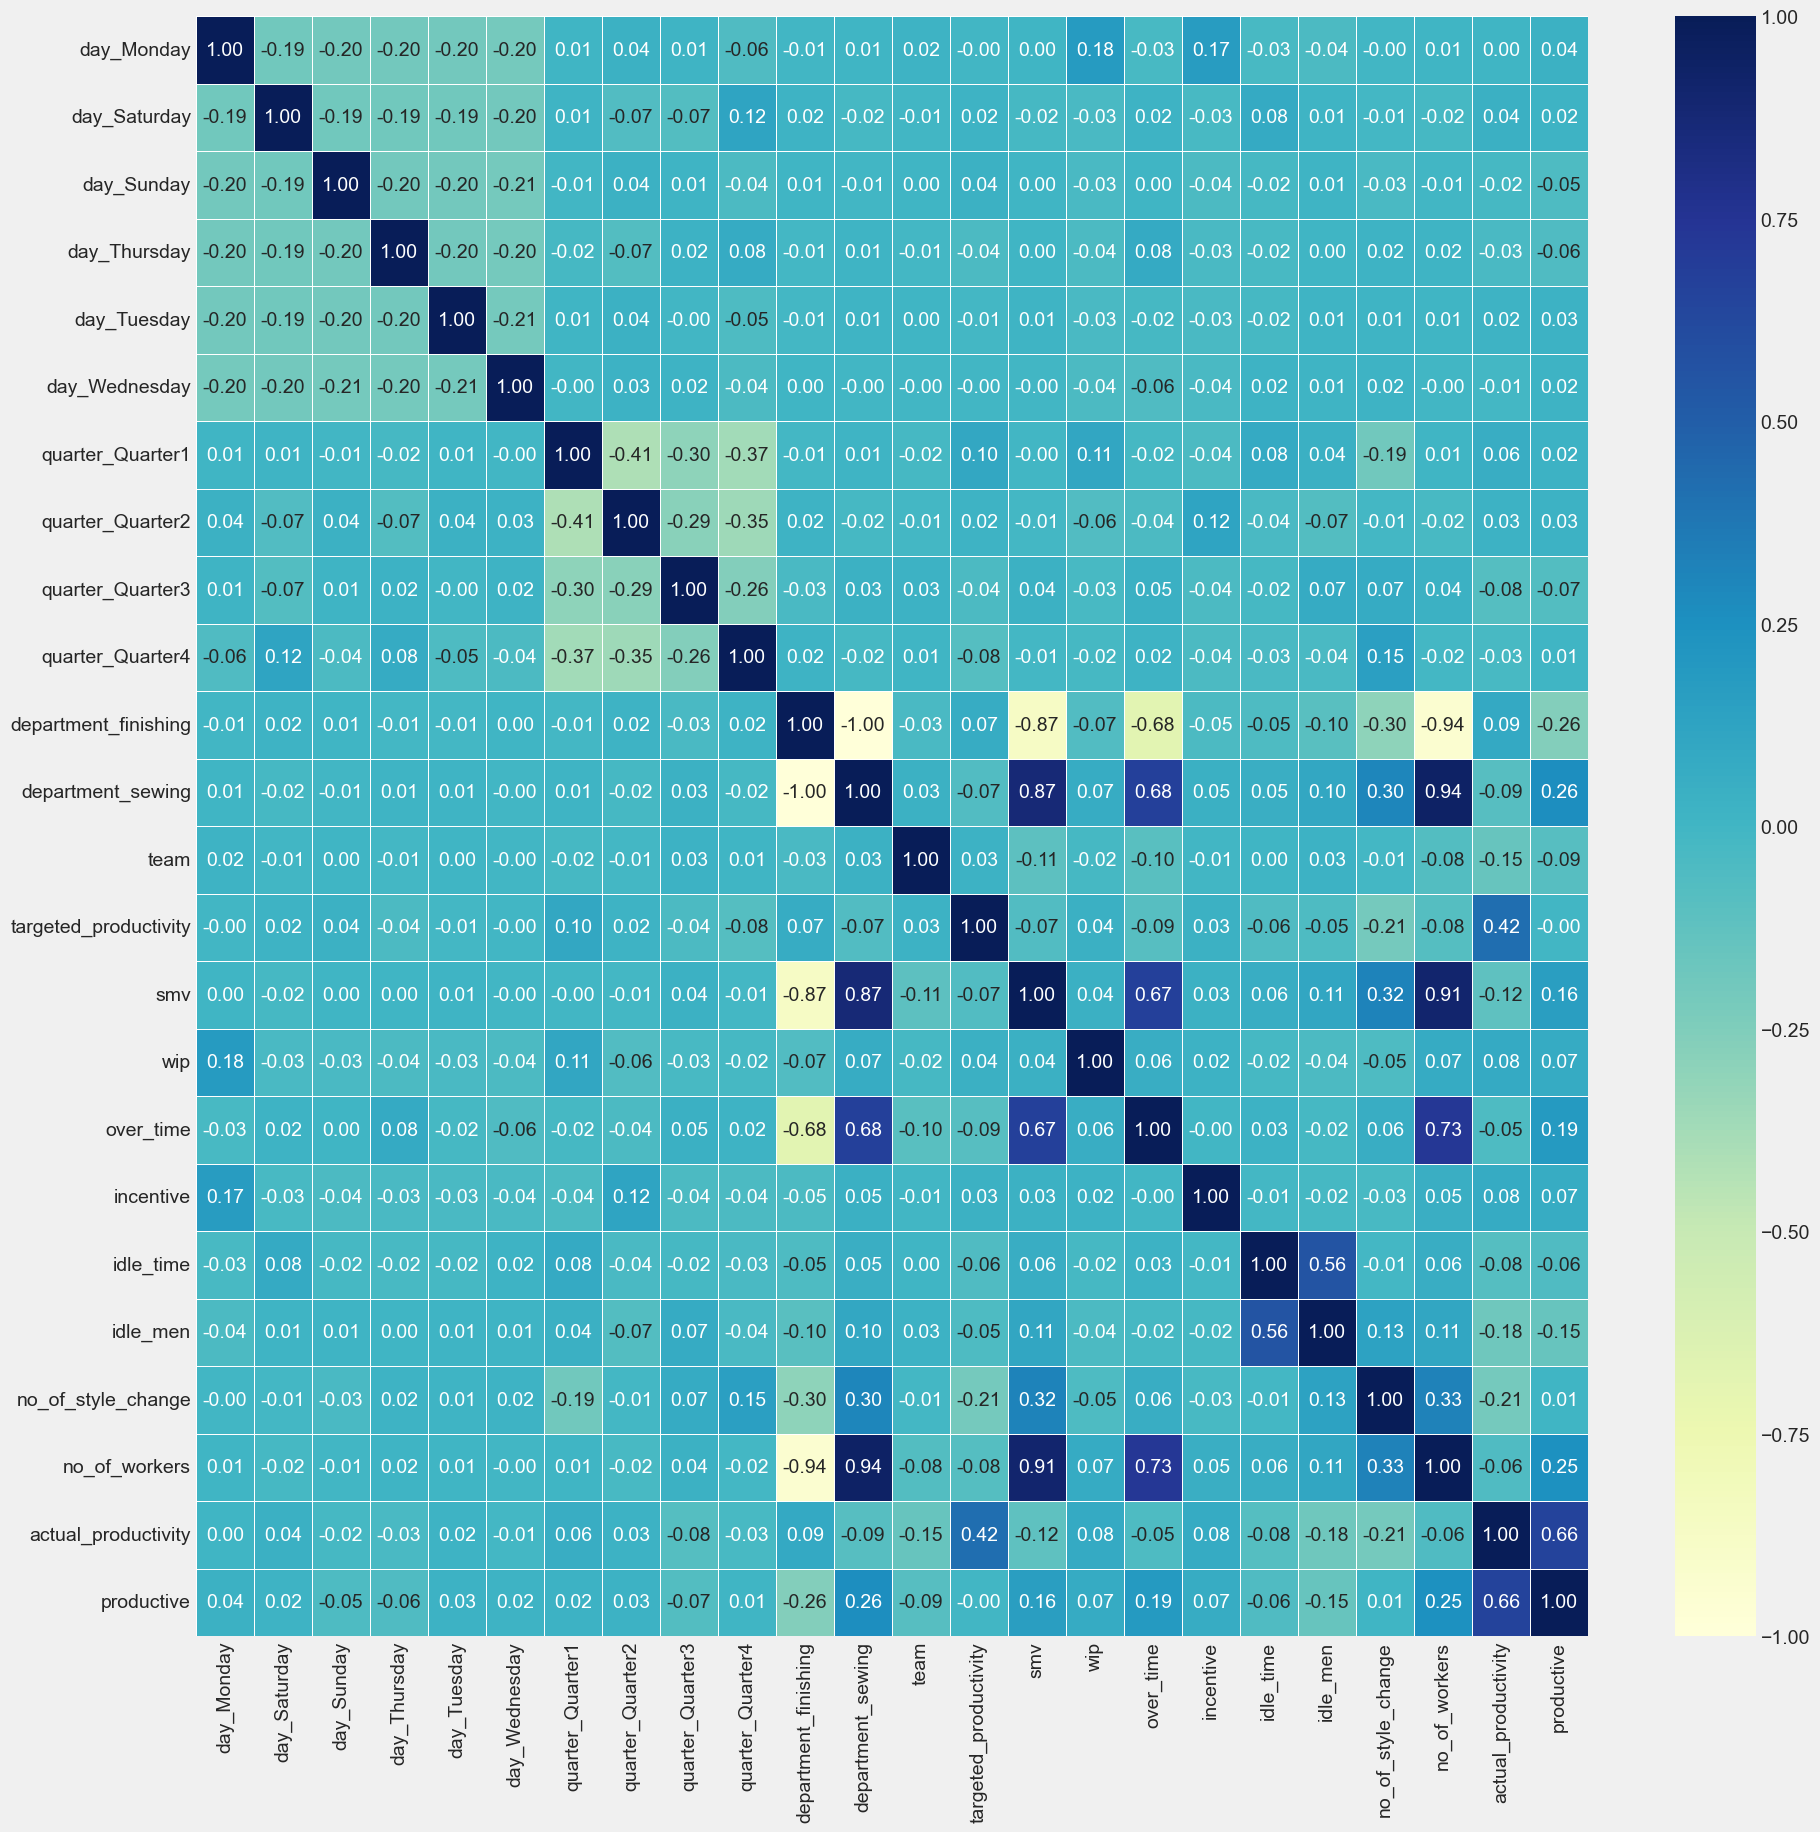

In [79]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_model.corr(),
            annot=True,
            linewidths=0.5,
            fmt= ".2f",
            cmap="YlGnBu")

There are a number of algorithms we will apply to select the relevant features and compare them with our own selection:
1. Principal Component Analysis (PCA)
2. Forward Selection
3. Backward Selection

While our problem is classification and regression, we'll be using the regression algorithms to determine the features for modelling. Then we will use those features on a tree classification algorithm to predict productivity.

We'll be using the complete dataframe, df_model2 that has all the features.

**Feature & Target Variables**

In [80]:
X = df_model.drop(columns=['actual_productivity', 'productive', 'date'])
y = df_model['productive']
cols = X.columns

In [81]:
X.head()

,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,...,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,8,0.80,26.16,1108.000000,7080,98,0.0,0,0,59.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1,0.75,3.94,997.742268,960,0,0.0,0,0,8.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,11,0.80,11.41,968.000000,3660,50,0.0,0,0,30.5
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,12,0.80,11.41,968.000000,3660,50,0.0,0,0,30.5
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,6,0.80,25.90,1170.000000,1920,50,0.0,0,0,56.0


**Principal Component Analysis**

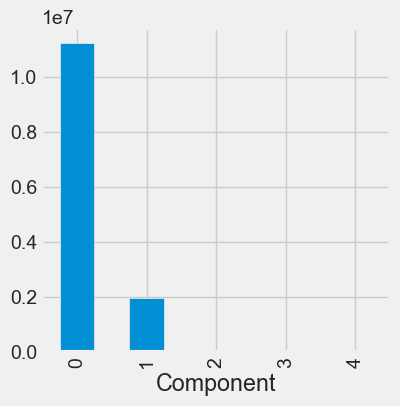

In [82]:
prod_pca = PCA(n_components=5)
prod_pca.fit(X)

exp_var = pd.DataFrame(prod_pca.explained_variance_)
ax = exp_var.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')
plt.show()

In [83]:
pd.DataFrame(prod_pca.components_, columns=X.columns)

,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,...,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers
0,-0.000003,0.000002,2.047434e-07,0.000009,-0.000002,-0.000007,-0.000002,-0.000005,0.000005,0.000002,...,-0.000100,-0.000003,0.002204,0.030614,0.999517,-0.000214,0.000117,-0.000018,0.000008,0.004867
1,0.000049,-0.000009,-8.817689e-06,-0.000012,-0.000009,-0.000010,0.000036,-0.000020,-0.000009,-0.000007,...,-0.000040,0.000004,-0.000065,0.999527,-0.030615,0.002947,-0.000229,-0.000095,-0.000016,0.000317
2,0.000392,-0.000068,-9.096946e-05,-0.000075,-0.000073,-0.000084,-0.000135,0.000348,-0.000100,-0.000114,...,-0.000167,0.000019,0.002486,-0.002943,0.000263,0.999965,-0.000895,-0.000410,-0.000066,0.007284
3,-0.000369,0.000843,1.622951e-04,0.001571,-0.000714,-0.001493,-0.000891,0.000033,-0.000240,0.001098,...,0.003391,0.000204,-0.431168,0.000367,0.005310,0.007473,-0.108887,-0.046378,-0.010855,-0.893939
4,-0.000629,0.002336,-6.648519e-04,-0.000491,-0.000793,0.000242,0.002873,-0.001300,-0.000635,-0.000938,...,0.002764,-0.000369,-0.049315,0.000278,0.000492,0.001815,0.983199,0.142099,-0.002448,-0.103184


<Figure size 2000x2000 with 0 Axes>

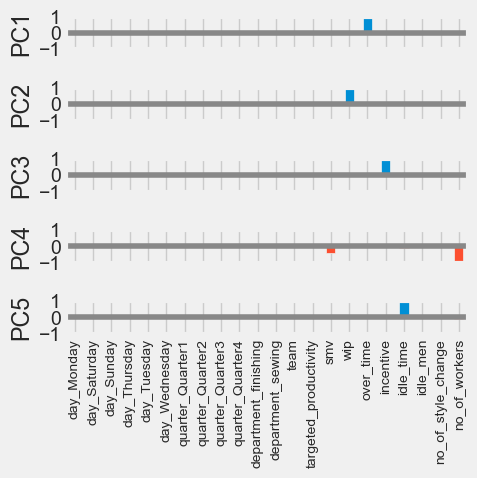

In [84]:
plt.figure(figsize=(20,20))

loadings = pd.DataFrame(prod_pca.components_, columns=X.columns)
maxPC = 1.01 * np.max(np.max(np.abs(loadings)))

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)
for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

locs, labels = plt.xticks()
plt.xticks(labels=labels, ticks=locs, size=10)
plt.tight_layout()
plt.show()

From the top 5 principal components, the following features covary: overtime, wip, incentive, number of workers, and idle time. PC1 also includes team and smv.

In [85]:
pd.DataFrame(prod_pca.components_, columns=X.columns)

,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,...,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers
0,-0.000003,0.000002,2.047434e-07,0.000009,-0.000002,-0.000007,-0.000002,-0.000005,0.000005,0.000002,...,-0.000100,-0.000003,0.002204,0.030614,0.999517,-0.000214,0.000117,-0.000018,0.000008,0.004867
1,0.000049,-0.000009,-8.817689e-06,-0.000012,-0.000009,-0.000010,0.000036,-0.000020,-0.000009,-0.000007,...,-0.000040,0.000004,-0.000065,0.999527,-0.030615,0.002947,-0.000229,-0.000095,-0.000016,0.000317
2,0.000392,-0.000068,-9.096946e-05,-0.000075,-0.000073,-0.000084,-0.000135,0.000348,-0.000100,-0.000114,...,-0.000167,0.000019,0.002486,-0.002943,0.000263,0.999965,-0.000895,-0.000410,-0.000066,0.007284
3,-0.000369,0.000843,1.622951e-04,0.001571,-0.000714,-0.001493,-0.000891,0.000033,-0.000240,0.001098,...,0.003391,0.000204,-0.431168,0.000367,0.005310,0.007473,-0.108887,-0.046378,-0.010855,-0.893939
4,-0.000629,0.002336,-6.648519e-04,-0.000491,-0.000793,0.000242,0.002873,-0.001300,-0.000635,-0.000938,...,0.002764,-0.000369,-0.049315,0.000278,0.000492,0.001815,0.983199,0.142099,-0.002448,-0.103184


In [86]:
pca_dict = dict()
for i in range(len(X.columns)):
    pca_dict[X.columns[i]] = prod_pca.components_[0][i]

pca_dict

{'day_Monday': -2.852485080029332e-06,
 'day_Saturday': 1.7590401320532315e-06,
 'day_Sunday': 2.047434413134758e-07,
 'day_Thursday': 9.355417795303053e-06,
 'day_Tuesday': -1.9635390109400014e-06,
 'day_Wednesday': -6.503177277799143e-06,
 'quarter_Quarter1': -2.130925582208065e-06,
 'quarter_Quarter2': -5.410012243438763e-06,
 'quarter_Quarter3': 5.093617395905495e-06,
 'quarter_Quarter4': 2.447320429741335e-06,
 'department_finishing': -9.998924034560233e-05,
 'department_sewing': 9.998924034560233e-05,
 'team': -0.00010024375129524716,
 'targeted_productivity': -2.5688305874407735e-06,
 'smv': 0.0022043888693242877,
 'wip': 0.03061428778512107,
 'over_time': 0.9995169491739739,
 'incentive': -0.00021413313384250945,
 'idle_time': 0.00011654743569333092,
 'idle_men': -1.79805207027188e-05,
 'no_of_style_change': 7.551731345748205e-06,
 'no_of_workers': 0.004866650660488228}

In [87]:
pc_features = sorted(pca_dict.items(), key=lambda x:x[1], reverse=True)[:5]
pc_features = [i[0] for i in pc_features]
pc_features

['over_time', 'wip', 'no_of_workers', 'smv', 'idle_time']

**Forward Selection**

In [88]:
model = LinearRegression()
forward = SequentialFeatureSelector(estimator=model,
                                    n_features_to_select=5,
                                    direction="forward")
forward.fit(X, y)
forward_features = forward.get_feature_names_out()
print(forward_features)

['department_finishing' 'team' 'smv' 'idle_men' 'no_of_workers']


**Backward Selection**

In [89]:
backward = SequentialFeatureSelector(estimator=model,
                                     n_features_to_select=5,
                                     direction="backward")
backward.fit(X, y)
backward_features = backward.get_feature_names_out()
print(backward_features)

['department_sewing' 'team' 'smv' 'idle_men' 'no_of_workers']


Let's consider our features list:

In [90]:
print('EDA Features: ', model_cols)
print('\n')
print('Principal Component Features: ', pc_features)
print('\n')
print('Forward Features: ', forward_features)
print('\n')
print('Backward Features: ', backward_features)

EDA Features:  ['day', 'quarter', 'department', 'team', 'over_time', 'incentive', 'no_of_style_change', 'targeted_productivity', 'actual_productivity', 'productive']


Principal Component Features:  ['over_time', 'wip', 'no_of_workers', 'smv', 'idle_time']


Forward Features:  ['department_finishing' 'team' 'smv' 'idle_men' 'no_of_workers']


Backward Features:  ['department_sewing' 'team' 'smv' 'idle_men' 'no_of_workers']


**Model Selection**

From our analysis, we'll use the following features to build our model:

In [91]:
model_features = ['team', 'smv', 'over_time',
                  'no_of_workers', 'idle_men',
                  'department_finishing', 'wip']

In [92]:
X = df_model[model_features]
y = df_model['productive']
X.head()

,team,smv,over_time,no_of_workers,idle_men,department_finishing,wip
0,8,26.16,7080,59.0,0,0.0,1108.000000
1,1,3.94,960,8.0,0,1.0,997.742268
2,11,11.41,3660,30.5,0,0.0,968.000000
3,12,11.41,3660,30.5,0,0.0,968.000000
4,6,25.90,1920,56.0,0,0.0,1170.000000


In [93]:
y.value_counts(normalize=True)

1    0.730994
0    0.269006
Name: productive, dtype: float64

### Building the Classification Model

**Finding the Best Model: Parameter Tuning**

In [94]:
scoring = ["precision", "recall", "f1", 'accuracy']

In [95]:

for i in scoring:
    params = {'criterion': ['gini', 'entropy'],
            'class_weight': [None, 'balanced'],
            'min_samples_split': list(range(12, 48, 3)),
            'max_depth': list(range(3, 7)),
            'min_samples_leaf': list(range(9, 19, 3))}

    class_tree = DecisionTreeClassifier(random_state=24)
    grid_recall = GridSearchCV(class_tree, param_grid=params,
                            scoring='precision', n_jobs=-1)
    
    grid_recall.fit(X, y)
    best_params = grid_recall.best_params_
    best_score = grid_recall.best_score_
    best_estimator = grid_recall.best_estimator_
    
    print(f'For {i} Scoring: \nbest_params: , {best_params}, \
          \nbest_estimator: , {best_estimator}, \
          \nbest_score: , {best_score}')
    


For precision Scoring: 
best_params: , {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 42},           
best_estimator: , DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_leaf=18, min_samples_split=42,
                       random_state=24),           
best_score: , 0.8390752002434988
For recall Scoring: 
best_params: , {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 42},           
best_estimator: , DecisionTreeClassifier(class_weight='balanced', max_depth=6,
                       min_samples_leaf=18, min_samples_split=42,
                       random_state=24),           
best_score: , 0.8390752002434988
For f1 Scoring: 
best_params: , {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 18, 'min_samples_split': 42},           
best_estimator: , DecisionTreeClassifier(class_weigh

**Build Classification Tree Model**

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=24)

In [97]:
clf = DecisionTreeClassifier(class_weight='balanced',
                             criterion='gini',
                             max_depth=6, min_samples_leaf=18,
                             min_samples_split=42,
                             random_state=24)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [98]:
clf.score(X_train, y_train)

0.7980884109916367

**Visualizing and Evaluating the Decision Tree**

In [99]:
print(clf.classes_)

[0 1]


We'll replace 0 with Unproductive and 1 with Productive in the class_names labels portion of the tree

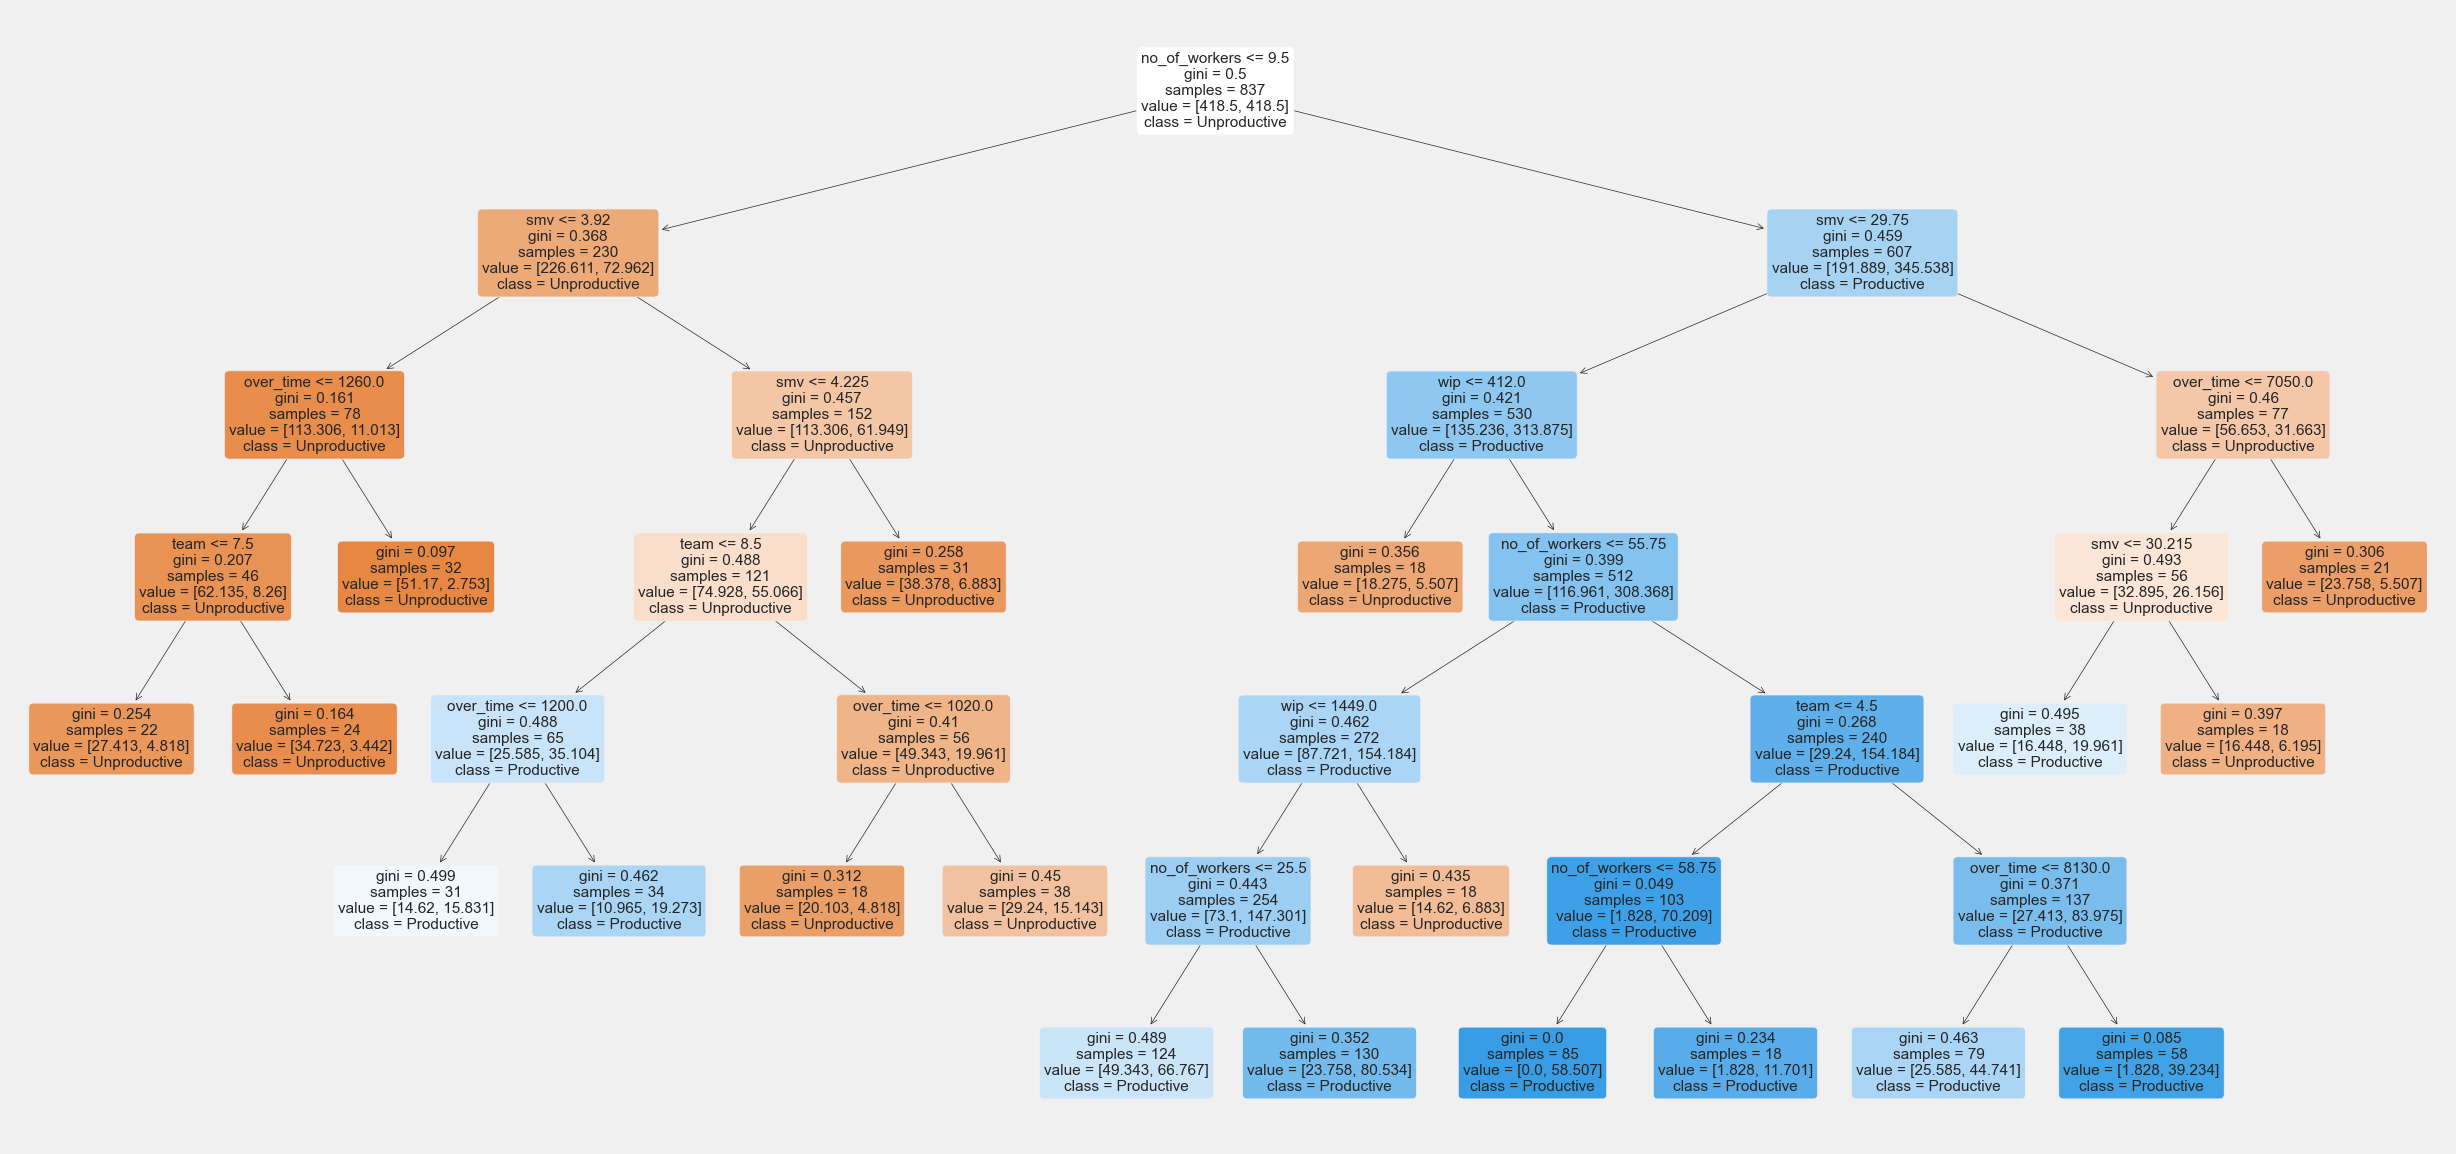

In [100]:
plt.figure(figsize=[28.0, 14.0])
plot_tree(clf,
          feature_names=X.columns,
          class_names=['Unproductive', 'Productive'],
          filled=True,
          proportion=False,
          precision=3,
          rounded=True,
          fontsize=11)

plt.show()

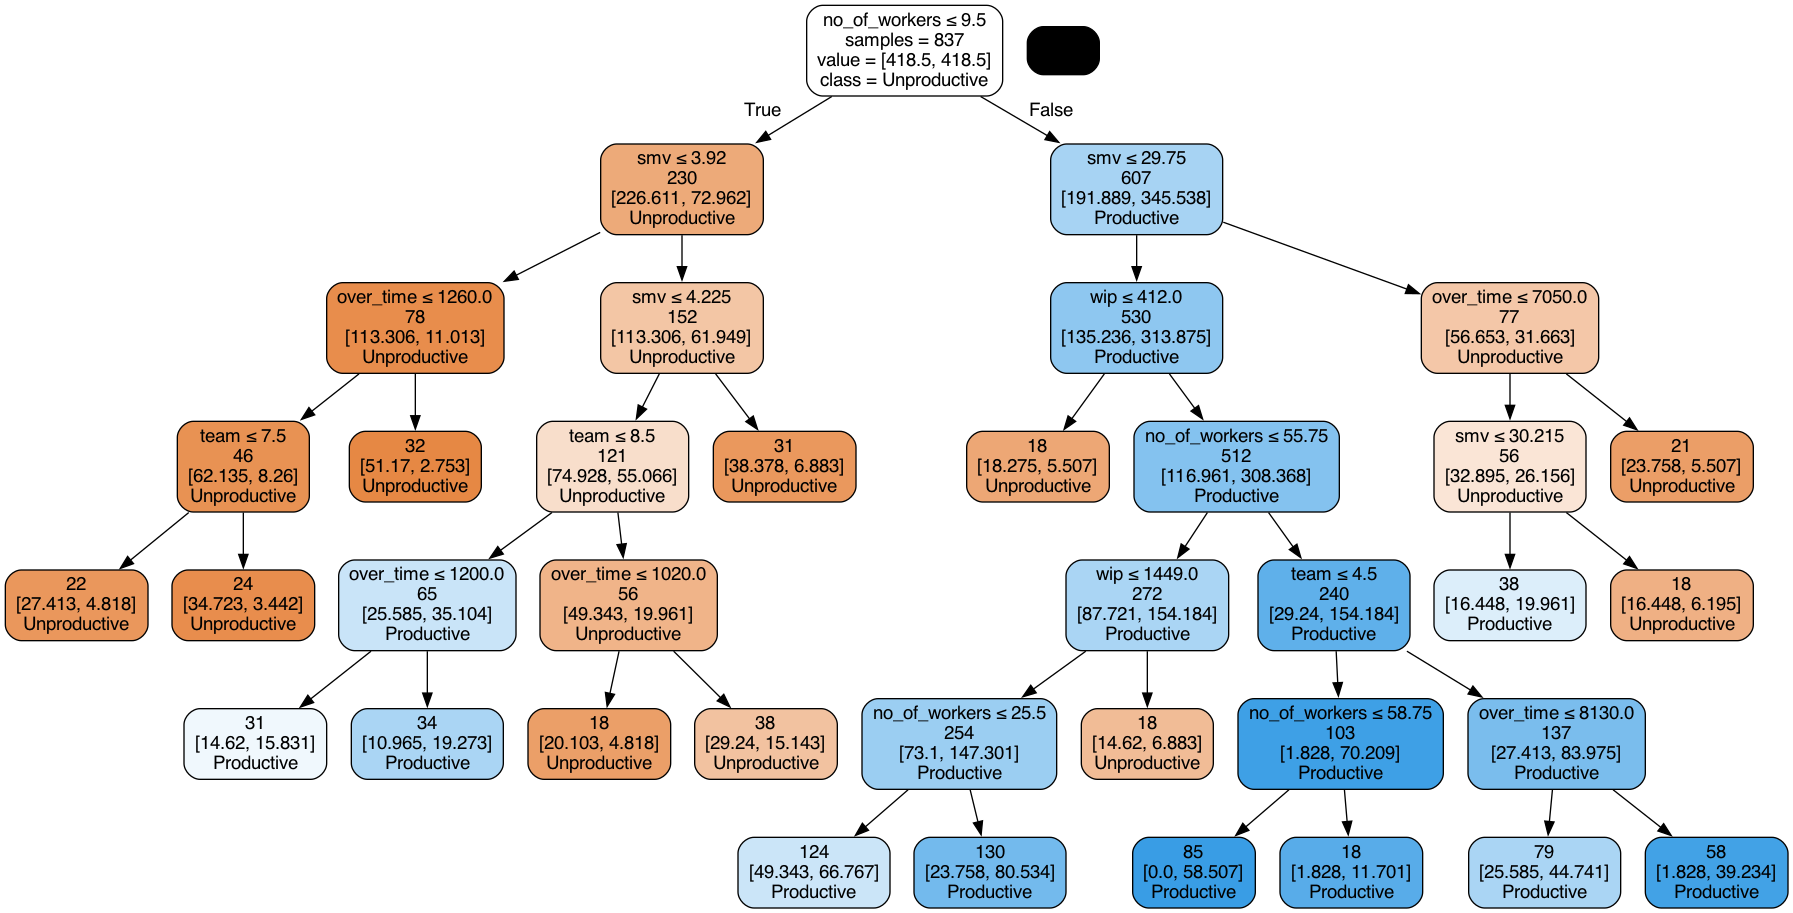

In [101]:
plotDecisionTree(clf, 
                 feature_names=X.columns, 
                 class_names=['Unproductive', 'Productive'])

Feature: 0, Score: 0.06845
Feature: 1, Score: 0.23897
Feature: 2, Score: 0.06406
Feature: 3, Score: 0.51919
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.10933


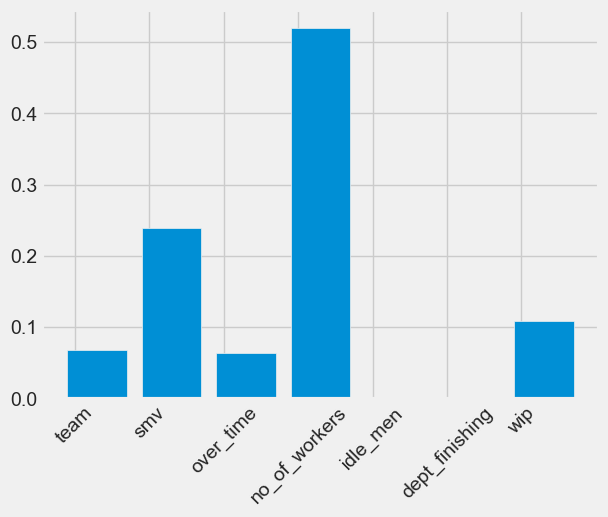

In [102]:
importance = clf.feature_importances_
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
locs, labels = plt.xticks()
locs=locs-0.3
new_labels = ['team', 'smv', 'over_time', 'no_of_workers',
              'idle_men', 'dept_finishing', 'wip']
plt.xticks(ticks=locs[1:8], labels=new_labels, rotation=45)
plt.show()

**Explaining our Tree**

The most important feature in our tree is the number of workers. It helps us split our tree into equal segments of productive and unproductive. After this first split, the most important feature is smv (Standard Minute Value), which represents the amount of time allocated to a task. The smaller the smv, the more likely the record will be unproductive. The next level is for overtime. At this level, overtime generally results in unproductivity. However, when higher overtime is split along with the wip (work in progress) feature, records are more likely to be productive.

At the next branch level, number of workers is the determinant for productivity. Throughout this tree, a large number of workers always breaks towards productivity. When combined with a small team and high overtime, our final nodes are productive.

**Model Evaluation**

In [103]:
confusion_matrix(y_test, y_pred)

array([[ 46,  47],
       [ 44, 223]])

In [104]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.49      0.50        93
           1       0.83      0.84      0.83       267

    accuracy                           0.75       360
   macro avg       0.67      0.66      0.67       360
weighted avg       0.74      0.75      0.75       360



**Explaining Model Evaluation**
*Important Terms:
TP (True Positive), FP (False Positive), TN (True Negative), FN (False Negative)*

The accuracy on this model is 75%. Accuracy measures the number of correct predictions over all the predictions. Our accuracy shows that although 1s are predicted at a high rate, 0s are predicted at a medium rate. However, the ratio of 1s to 0s in the dataset favourably weighs the accuracy score.

Precision is a measure of how many of the positive predictions made are correct (true positives / TPs). Formula = TP / (TP + FP)
TPs for 1 is high but for 0 is mid. Precision across the dataset is 67%.

Recall/ Sensitivity is a measure of how many of the positive cases the classifier correctly predicted, over all the positive cases in the data. Formula = TP / (TP + FN). Recall across the dataset is 67%.

F1-Score is a measure combining both precision and recall. It is generally described as the harmonic mean of the two. Formula = 2 * (Precision * Recall) / (Precision + Recall). F1-Score across the dataset is 67%.

This model is generally mid. Let's tune our parameters for better scores.

**Tuning Parameters and Retraining the Model**

Let's consider that our first model's accuracy of 75% is because of its inability to adequately predict 0 values due to the size of 0 values in the dataset (although balanced class weight should address this). We'll attempt to fix this by balancing our dataset.

In [105]:
y_0 = y.loc[y == 0]

y_1 = y.loc[y == 1]
y_1 = y_1.sample(322)

new_index = list(y_0.index)
new_index.extend(list(y_1.index))

old_index = [i for i in df_model.index if i not in new_index]
new_df_model = df_model.drop(index=old_index)
new_df_model.sample(5)

,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday,quarter_Quarter1,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,...,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity,productive
206,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,11.61,760.000000,4470,50,0.0,0,0,31.5,0.800077,1
1102,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,4.60,997.742268,3600,0,0.0,0,0,15.0,0.590741,0
143,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,4.15,997.742268,2160,0,0.0,0,0,12.0,0.712626,0
1196,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,2.90,997.742268,720,0,0.0,0,0,6.0,0.394722,0
1044,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,4.60,997.742268,3360,0,0.0,0,0,8.0,0.354444,0


In [106]:
X1 = new_df_model[model_features]
y1 = new_df_model['productive']
X1.head()

,team,smv,over_time,no_of_workers,idle_men,department_finishing,wip
1,1,3.94,960,8.0,0,1.0,997.742268
8,2,19.87,6000,55.0,0,0.0,733.000000
10,9,28.08,6900,57.5,0,0.0,872.000000
11,10,19.31,6480,54.0,0,0.0,578.000000
12,5,11.41,3660,30.5,0,0.0,668.000000


In [107]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=24)

clf = DecisionTreeClassifier(class_weight='balanced',
                             criterion='gini',
                             max_depth=6, min_samples_leaf=18,
                             min_samples_split=42,
                             random_state=24)

clf.fit(X1_train, y1_train)
y1_pred = clf.predict(X1_test)

In [108]:
clf.score(X1_train, y1_train)

0.7333333333333333

In [109]:
print(classification_report(y1_test, y1_pred))

              precision    recall  f1-score   support

           0       0.73      0.69      0.71       105
           1       0.66      0.71      0.68        89

    accuracy                           0.70       194
   macro avg       0.70      0.70      0.70       194
weighted avg       0.70      0.70      0.70       194



After balancing the dataset, accuracy drops.

Let's finetune the model parameters instead. We'll reduce depth and samples leaf and increase samples split.

In [110]:
clf = DecisionTreeClassifier(criterion='entropy',
                             max_depth=4, min_samples_leaf=4,
                             min_samples_split=50,
                             random_state=24)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

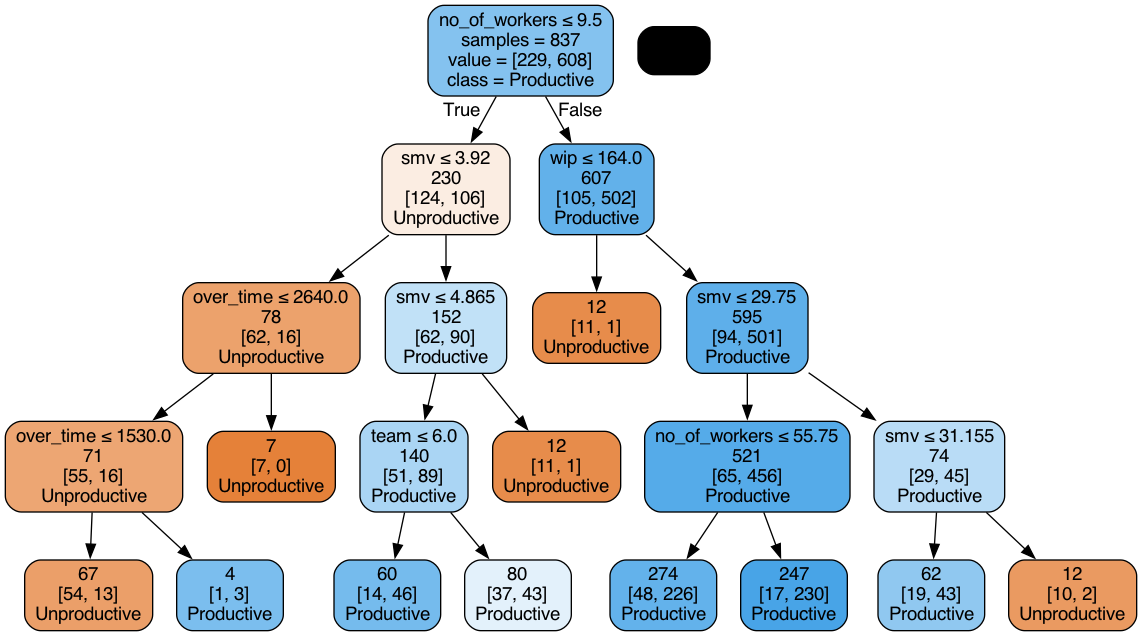

In [111]:
plotDecisionTree(clf,
                 feature_names=X.columns,
                 class_names=['Unproductive', 'Productive'])

In [112]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.29      0.42        93
           1       0.80      0.97      0.87       267

    accuracy                           0.79       360
   macro avg       0.77      0.63      0.65       360
weighted avg       0.78      0.79      0.76       360



Accuracy increases but recall and f1 score for 0 values drastically reduce, which reduce our macro averages. This is not a better model. Let's try a model with fewer parameters.

In [113]:
clf = DecisionTreeClassifier(max_depth=3, random_state=24)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

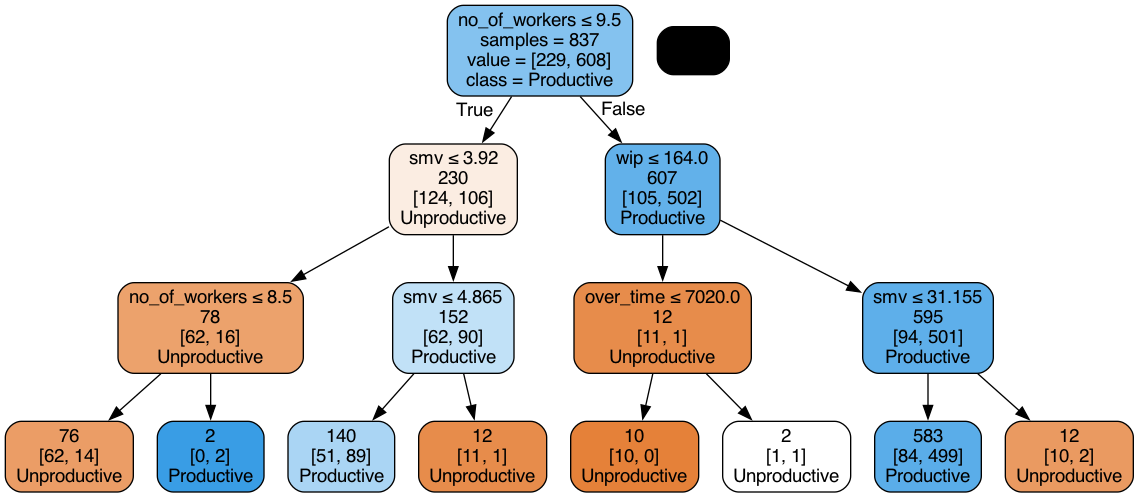

In [114]:
plotDecisionTree(clf,
                 feature_names=X.columns,
                 class_names=['Unproductive', 'Productive'])

In [115]:
round(clf.score(X_train, y_train), 2)

0.82

In [116]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.30      0.43        93
           1       0.80      0.97      0.87       267

    accuracy                           0.79       360
   macro avg       0.78      0.63      0.65       360
weighted avg       0.79      0.79      0.76       360



This model slightly improves on the failings of the previous one, but it's still not as good as the first model.

We believe the first model is the best of the 3 trained models.

**Cross Validation Metrics**

We'll use cross validation to evaluate our tree model further. Cross validation divides our dataset into folds (number of folds is determined by the cv parameter) and creates that many copies of the dataset where each copy will have a different segment of observations compared to the test set. The algorithm will then iterate on each copy and will output a list of the accuracy scores for all iterations.

This is a practical way to ensure that we didn't get the original accuracy score by pure chance by comparing it with several other possible results.

In [117]:
clf = DecisionTreeClassifier(class_weight='balanced',
                             criterion='gini',
                             max_depth=6, min_samples_leaf=18,
                             min_samples_split=42,
                             random_state=24)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

Let's cross validate our accuracy metric.

In [118]:
scores = cross_val_score(clf, X, y, cv = 10)
print("Cross Validation Accuracy Scores:", scores.round(2))

Cross Validation Accuracy Scores: [0.75 0.78 0.8  0.82 0.74 0.73 0.6  0.71 0.79 0.71]


In [119]:
print("Mean Cross Validation Score:", scores.mean().round(2))

Mean Cross Validation Score: 0.74


Let's cross validate other evaluation metrics

In [120]:
multiple_cross_scores = cross_validate(clf, X, y,
                                       cv = 10,
                                       scoring= ("precision", "recall", "f1"))

print("Cross Validation Precision:", multiple_cross_scores["test_precision"].round(2))

Cross Validation Precision: [0.85 0.87 0.85 0.81 0.79 0.79 0.75 0.86 0.87 0.85]


In [121]:
print("Mean Cross Validated Precision:", round(multiple_cross_scores["test_precision"].mean(), 2))

Mean Cross Validated Precision: 0.83


In [122]:
print(multiple_cross_scores["test_recall"].round(2))

[0.81 0.83 0.89 0.98 0.88 0.86 0.67 0.71 0.84 0.72]


In [123]:
print("Mean Cross Validated Recall:", round(multiple_cross_scores["test_recall"].mean(), 2))

Mean Cross Validated Recall: 0.82


In [124]:
print(multiple_cross_scores["test_f1"].round(2))

[0.83 0.85 0.87 0.89 0.83 0.82 0.71 0.78 0.85 0.78]


In [125]:
print("Mean Cross Validated F1:", round(multiple_cross_scores["test_f1"].mean(), 2))

Mean Cross Validated F1: 0.82


### Using Random Forests

In [126]:
scoring = ["precision", "recall", "f1", 'accuracy']

for i in scoring:
    params = {'criterion': ['gini', 'entropy'],
              'n_estimators':[50, 70, 100, 150],
              'class_weight': [None, 'balanced'],
              'min_samples_split': list(range(12, 48, 3)),
              'max_depth': list(range(3, 7)),
              'min_samples_leaf': list(range(9, 19, 3))}

    class_tree= RandomForestClassifier(random_state=24)
    random_recall = RandomizedSearchCV(class_tree,
                                       param_distributions=params,
                                       scoring=i,
                                       n_iter=10,
                                       cv=9,
                                       n_jobs=-1)

    random_recall.fit(X, y)
    best_params = random_recall.best_params_
    best_score = random_recall.best_score_
    best_estimator = random_recall.best_estimator_

    print(f'For {i} Scoring: \nbest_params: , {best_params}, \
          \nbest_estimator: , {best_estimator}, \
          \nbest_score: , {best_score}')



For precision Scoring: 
best_params: , {'n_estimators': 50, 'min_samples_split': 21, 'min_samples_leaf': 18, 'max_depth': 4, 'criterion': 'entropy', 'class_weight': 'balanced'},           
best_estimator: , RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, min_samples_leaf=18, min_samples_split=21,
                       n_estimators=50, random_state=24),           
best_score: , 0.8353905745786645
For recall Scoring: 
best_params: , {'n_estimators': 70, 'min_samples_split': 36, 'min_samples_leaf': 18, 'max_depth': 5, 'criterion': 'entropy', 'class_weight': None},           
best_estimator: , RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=18,
                       min_samples_split=36, n_estimators=70, random_state=24),           
best_score: , 0.9623278864810528
For f1 Scoring: 
best_params: , {'n_estimators': 70, 'min_samples_split': 21, 'min_samples_leaf': 12, 'max_depth': 3, 'criterion': 'entropy', '

**Random Forest Model**

In [127]:
random_clf = RandomForestClassifier(max_depth=3,
                                    min_samples_leaf=9,
                                    min_samples_split=24,
                                    n_estimators=150,
                                    random_state=24,
                                    oob_score=True,
                                    n_jobs=-1)

random_clf.fit(X_train, y_train)
y_pred = random_clf.predict(X_test)


In [128]:
random_clf.score(X_train, y_train)


0.7825567502986858

In [129]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.22      0.34        93
           1       0.78      0.98      0.87       267

    accuracy                           0.78       360
   macro avg       0.79      0.60      0.60       360
weighted avg       0.79      0.78      0.73       360



In [130]:
random_for_class_oob = random_clf.oob_score_

oob_predictions = random_clf.oob_decision_function_
random_clf_classes = random_clf.classes_

oob_clf = pd.DataFrame(data=oob_predictions,
                       columns=random_clf_classes)

oob_clf['y_pred'] = oob_clf.idxmax(axis=1)
oob_clf['y_test'] = y
oob_accuracy = accuracy_score(oob_clf['y_test'], oob_clf['y_pred'])
print(oob_accuracy)

0.7025089605734767


**Hyperparameter Tuning**

In [131]:
r_clf = RandomForestClassifier(class_weight='balanced', max_depth=4,
                               min_samples_leaf=18, min_samples_split=24,
                               n_estimators=50, random_state=24)
r_clf.fit(X_train, y_train)
y_pred = random_clf.predict(X_test)
random_clf.score(X_train, y_train)


0.7825567502986858

In [132]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.22      0.34        93
           1       0.78      0.98      0.87       267

    accuracy                           0.78       360
   macro avg       0.79      0.60      0.60       360
weighted avg       0.79      0.78      0.73       360



In [133]:
r_clf = RandomForestClassifier(criterion='entropy', max_depth=3,
                               min_samples_leaf=18, min_samples_split=42,
                               n_estimators=150, random_state=24)
r_clf.fit(X_train, y_train)
y_pred = random_clf.predict(X_test)
random_clf.score(X_train, y_train)


0.7825567502986858

In [134]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.22      0.34        93
           1       0.78      0.98      0.87       267

    accuracy                           0.78       360
   macro avg       0.79      0.60      0.60       360
weighted avg       0.79      0.78      0.73       360



In [135]:
r_clf = RandomForestClassifier(class_weight='balanced', criterion='entropy',
                               max_depth=5,
                               min_samples_leaf=9, min_samples_split=39,
                               n_estimators=70, random_state=24)
r_clf.fit(X_train, y_train)
y_pred = random_clf.predict(X_test)
random_clf.score(X_train, y_train)


0.7825567502986858

In [136]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.22      0.34        93
           1       0.78      0.98      0.87       267

    accuracy                           0.78       360
   macro avg       0.79      0.60      0.60       360
weighted avg       0.79      0.78      0.73       360



In [137]:
pd.crosstab(y_test, y_pred)

col_0,0,1
productive,,
0,20,73
1,5,262


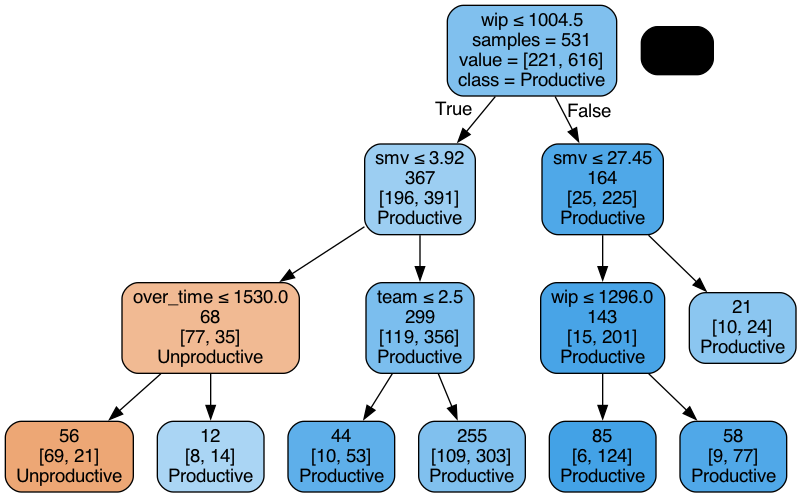

In [138]:
plotDecisionTree(random_clf.estimators_[0],
                 feature_names=X.columns,
                 class_names=['Unproductive', 'Productive'])

Feature: 0, Score: 0.05173
Feature: 1, Score: 0.32136
Feature: 2, Score: 0.11131
Feature: 3, Score: 0.26591
Feature: 4, Score: 0.00704
Feature: 5, Score: 0.10145
Feature: 6, Score: 0.14121


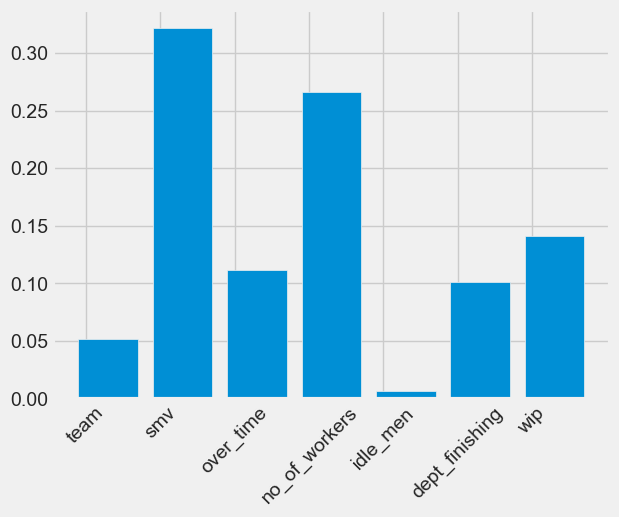

In [139]:
importance = random_clf.feature_importances_
for i, v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i, v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
locs, labels = plt.xticks()
locs = locs - 0.3
new_labels = ['team', 'smv', 'over_time', 'no_of_workers',
              'idle_men', 'dept_finishing', 'wip']
plt.xticks(ticks=locs[1:8], labels=new_labels, rotation=45)
plt.show()

**Explaining our Random Forest Model**
All the models tested have the same accuracy, precision, recall and f-1 score. The models struggled with recall, which is a measurement of how much correct positives over the total positives predicted by the model. This adversely affected the f-1 score, which we've seen is the harmonized average of the precision and recall. Our confusion matrix shows a high success rate for productive and a low success rate for unproductive predictions. However, accuracy is high given how high the true positives were.

However, this model's train and test accuracy is identical. The accuracy is also higher in this case than in the decision tree model.

From our visual tree and feature importance bar chart, the most important features were smv and number of workers. This replicates the finding from our single decision tree.

### Conclusion

Our tree and forest models have a high enough accuracy without overfitting the data. They are good models.